In [ ]:
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install -U albumentations==0.3.0
!pip install --upgrade albumentations

In [ ]:
import tensorflow as tf
print(tf. __version__)

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
decompress = False
if(decompress == True):
  import zipfile
  with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/data/mydataset')

In [ ]:
DATA_DIR = '/content/data/mydataset/dataset/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background','strip']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background','strip'])

image, mask = dataset[5] # get some sample

visualize(
    image=image, 
    bg_mask=mask[..., 0].squeeze(),
    strip_mask=mask[..., 0].squeeze(),
)

In [ ]:
## Dummy function as I am not going to use albumentations
import albumentations as A
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    return A.Compose([])

def get_validation_augmentation():
    return A.Compose([])

def get_preprocessing(preprocessing_fn):
    return A.Compose([])

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background','strip'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    strip_mask=mask[..., 0].squeeze(),
)

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()


BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['strip']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [ ]:

#create model 
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)
test_dataset = Dataset(x_test_dir, y_test_dir, classes=CLASSES)
valid_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES)


train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
image, mask = train_dataset[12] # get some sample
visualize(
    image=image, 
    strip_mask=mask[..., 0].squeeze(),
)

In [ ]:
m_del = False
if(m_del == True):
  files = os.listdir('/content/data/mydataset/dataset/valannot/')
  for m_file in files:
    if(m_file == '.DS_Store'):
      print(m_file)
      os.remove('/content/data/mydataset/dataset/valannot/' + '.DS_Store')

In [ ]:
model.load_weights('best_model.h5') 

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
58/58 [==============================] - 144s 2s/step - loss: 0.0200 - iou_score: 0.9918 - f1-score: 0.9959 - val_loss: 0.0353 - val_iou_score: 0.9782 - val_f1-score: 0.9857 - lr: 1.0000e-04
Epoch 2/10
58/58 [==============================] - 143s 2s/step - loss: 0.0181 - iou_score: 0.9922 - f1-score: 0.9961 - val_loss: 0.0339 - val_iou_score: 0.9785 - val_f1-score: 0.9858 - lr: 1.0000e-04
Epoch 3/10
58/58 [==============================] - 146s 3s/step - loss: 0.0162 - iou_score: 0.9931 - f1-score: 0.9966 - val_loss: 0.0326 - val_iou_score: 0.9794 - val_f1-score: 0.9863 - lr: 1.0000e-04
Epoch 4/10
58/58 [==============================] - 141s 2s/step - loss: 0.0148 - iou_score: 0.9935 - f1-score: 0.9968 - val_loss: 0.0333 - val_iou_score: 0.9799 - val_f1-score: 0.9865 - lr: 1.0000e-04
Epoch 5/10
58/58 [==============================] - 140s 2s/step - loss: 0.0133 - iou_score: 0.9942 - f1-score: 0.9971 - val_loss: 0.0328 - val_iou_score: 0.9790 - val_f1-score: 0.9861 - lr: 1

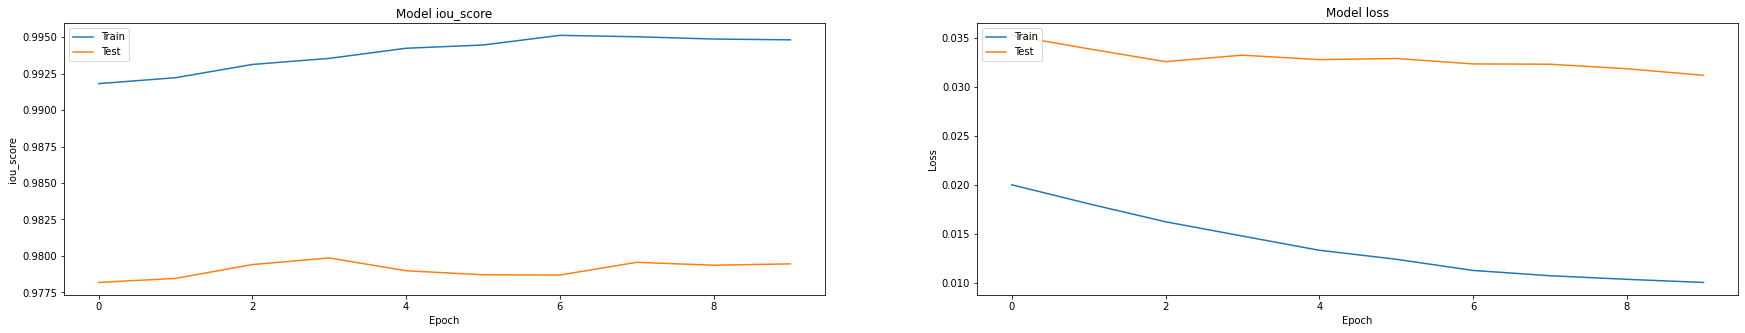

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
model.load_weights('best_model.h5') 

n = 1
ids = [7]
for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
n = len(test_dataset)
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    cluttered_img = image[0]
    mask_img = pr_mask[0]
    mask_img = mask_img.astype('uint8')
    mask_img = mask_img[:,:,0]

    r,g,b = cluttered_img[:,:,0],cluttered_img[:,:,1],cluttered_img[:,:,2]
    rr = np.multiply(r,mask_img)
    gg = np.multiply(g,mask_img)
    bb = np.multiply(b,mask_img)
    enhanced_img = cv2.merge((rr,gg,bb))
    f_img = cv2.hconcat([cluttered_img,enhanced_img])
    plt.imshow(f_img)
    plt.show()

    save_path = '/content/data/savedataset/IMG_' + str(i) + '.png'
    f_img = cv2.cvtColor(f_img,cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path,f_img)